## Статистический анализ данных сервиса аренды самокатов GoFast

В данном проекте буду исследованы данные сервиса проката самокатов GoFast, в том числе: 
- данные о пользователях, 
- данные о совершённых поездках,
- условиях подписки.

Цель проекта изучить полученные данные, провести предобработку при необходимости, визуализивровать ключевые параметры, а также проверить следующие гипотезы:
- Тратят ли пользователи с подпиской больше времени на поездки?
- Верно ли, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st
from math import factorial
from scipy.stats import binom, norm

pd.options.display.float_format = '{:,.0f}'.format

#### 1. Загрузка данных

In [101]:
#информация о пользователях, их поездках и подписках
users = pd.read_csv('https://users_go.csv')
rides = pd.read_csv('https://rides_go.csv')
subscriptions = pd.read_csv('https://subscriptions_go.csv')

#### 2. Предобработка данных

In [102]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [103]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [104]:
users.duplicated().sum()

np.int64(31)

Пропусков в данных нет, типы данных указаны корректно, но есть дубликаты. Уберём их.

In [105]:
users = users.drop_duplicates()
users.duplicated().sum()

np.int64(0)

In [106]:
# Может быть наличие пробелов в начале/конце строковых значений, обработаем это.
for column in users.columns:
    if users[column].dtype == 'object':
        users[column] = users[column].str.strip()

In [107]:
rides.head()

,user_id,distance,duration,date
0,1,"4,410",26,2021-01-01
1,1,"2,618",16,2021-01-18
2,1,754,6,2021-04-20
3,1,"2,695",19,2021-08-11
4,1,"4,029",26,2021-08-28


In [108]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [109]:
# Не корректно указан формат даты
rides['date'] = pd.to_datetime(rides['date'])
# Создаем новый столбец с номером месяца
rides['month_number'] = rides['date'].dt.month

In [110]:
rides.head()

,user_id,distance,duration,date,month_number
0,1,"4,410",26,2021-01-01,1
1,1,"2,618",16,2021-01-18,1
2,1,754,6,2021-04-20,4
3,1,"2,695",19,2021-08-11,8
4,1,"4,029",26,2021-08-28,8


In [111]:
rides.duplicated().sum()

np.int64(0)

In [112]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [113]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [114]:
# Может быть наличие пробелов в начале/конце строковых значений, обработаем это.
for column in subscriptions.columns:
    if subscriptions[column].dtype == 'object':
        subscriptions[column] = subscriptions[column].str.strip()

Результаты предобработки данных:
- пропусков в данных не обнаружено,
- обработано возможное наличик пробелов в начале/конце строковых значений,
- изменён формат даты в датасете с поездками,
- найдены и устранены дубликаты в датасете с пользователями.

#### 3. Исследовательский анализ данных
Описание и визуализация общей информации о пользователях и поездках

3.1 Частота встречаемости городов

In [115]:
city_frequency = users.groupby('city')['city'].agg(frequency='count').sort_values(by='frequency')
city_frequency

,frequency
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


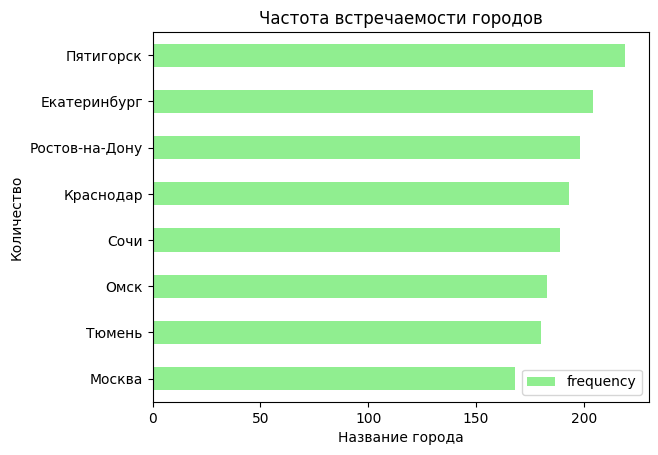

In [116]:
city_frequency.plot(kind='barh', color='lightgreen')

plt.xlabel('Название города')
plt.ylabel('Количество')
plt.title('Частота встречаемости городов')
plt.show()


Видно, что сервис наиболее популярен в Пятигорске, а вот Москва заняла последнее место.

3.2 Соотношение пользователей с подпиской и без подписки

In [117]:
subscription_type = users.groupby('subscription_type')['user_id'].agg(number_of_users='count')
subscription_type['ratio (%)'] = round(subscription_type['number_of_users']/len(users)*100)
subscription_type

,number_of_users,ratio (%)
subscription_type,,
free,835,54
ultra,699,46


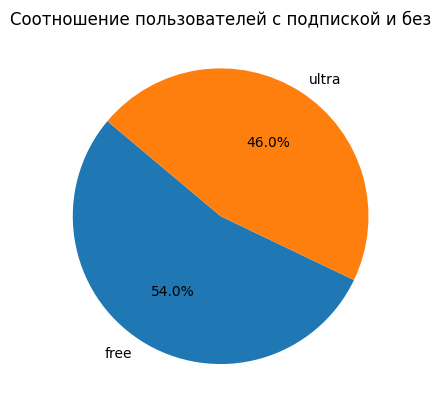

In [118]:
labels = subscription_type.index
sizes = subscription_type['ratio (%)']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Соотношение пользователей с подпиской и без')
plt.show()

3.3 Возраст пользователей

In [119]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [120]:
min_age = users['age'].min()
max_age = users['age'].max()
median_age = users['age'].median()
print(
f'Минимальный возраст пользователей: {min_age}\n\
Максимальный возраст пользователей: {max_age}\n\
Средний возраст: {median_age}')

Минимальный возраст пользователей: 12
Максимальный возраст пользователей: 43
Средний возраст: 25.0


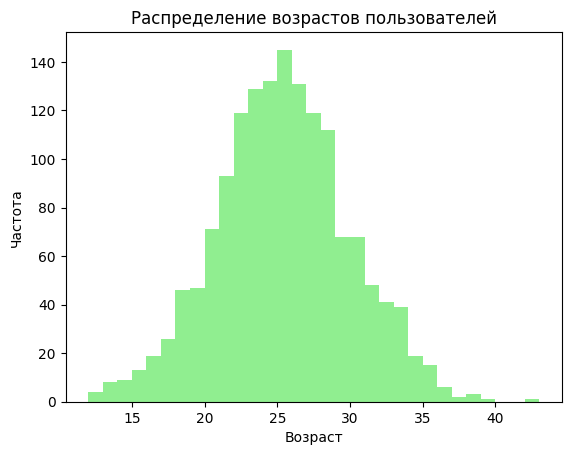

In [121]:
plt.hist(users['age'], bins=31, color='lightgreen') # кол-во корзин по числу возрастов 43-12
plt.title('Распределение возрастов пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

Видно, что сервис наиболее популярен у пользователей 20-30 лет. 

3.4 Расстояние, которое пользователь преодолел за одну поездку

In [122]:
# Посмотрим общую информацию по рассточниям
rides['distance'].describe()

count   18,068
mean     3,071
std      1,117
min          1
25%      2,543
50%      3,134
75%      3,776
max      7,211
Name: distance, dtype: float64

In [123]:
# Странное минимальное значение
rides.loc[rides['distance'] <= 1]

,user_id,distance,duration,date,month_number
11555,1069,1,10,2021-01-31,1


In [124]:
# Уберу его
rides = rides.loc[rides['distance'] > 1]

In [125]:
min_distance = round(rides['distance'].min(), 2)
max_distance = round(rides['distance'].max(), 2)
median_distance = round(rides['distance'].median())

print(
f'Минимальное расстояние поездки: {min_distance} м.\n\
Максимальное расстояние поездки: {max_distance} м.\n\
Среднее расстояние за одну поездку: {median_distance} м.')

Минимальное расстояние поездки: 2.57 м.
Максимальное расстояние поездки: 7211.01 м.
Среднее расстояние за одну поездку: 3134 м.


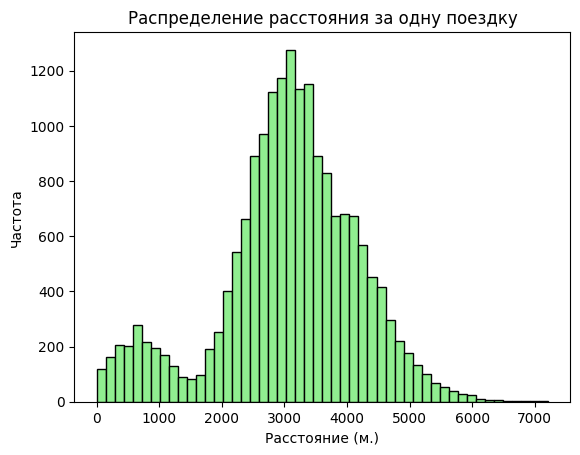

In [126]:
plt.hist(rides['distance'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Распределение расстояния за одну поездку')
plt.xlabel('Расстояние (м.)')
plt.ylabel('Частота')
plt.show()

Есть два пика, из чего видно, что чаще всего самокатом пользуются либо на коротких (около 600 м.), либо на длинных (около 3 км.) поездках.

3.5 Продолжительность поездок

In [127]:
rides['duration'].describe()

count   18,067
mean        18
std          6
min          0
25%         14
50%         18
75%         22
max         41
Name: duration, dtype: float64

In [128]:
# Немного смущает минимальное занчение поездки 0 минут.
rides.loc[rides['duration'] < 1]

,user_id,distance,duration,date,month_number
6531,701,"4,196",0,2021-08-31,8
6570,704,"4,831",0,2021-10-14,10
6680,712,"4,684",0,2021-03-04,3
6695,713,"5,216",0,2021-02-25,2
6768,718,"5,197",0,2021-02-11,2
...,...,...,...,...,...
17004,1460,"5,531",0,2021-01-19,1
17242,1477,"6,725",0,2021-01-12,1
17314,1483,"4,445",0,2021-03-06,3
17505,1496,"5,723",0,2021-02-14,2


Видно, что есть поездки с нулевой длительностью, хотя, по расстоянию видно, что это были полноценные поездки. Скорее всего в данных возникла ошибка. Заполним эти пропуски в соответствии с дальностью поездки, т.к. между расстоянием и временем существует линейная зависимость. Можно попробовать сделать регрессию продолжительности поездки на дальность поездки.

In [129]:
# Подбираем коэффициенты линейной регрессии времени на расстояние
a, b = np.polyfit(rides['distance'], rides['duration'], 1)

# Делаем замену ошибочного времени 0 мин.
rides.loc[rides['duration'] < 1, 'duration'] =\
    rides.loc[rides['duration'] < 1, 'distance'].apply(lambda x: a * x + b)

In [130]:
rides['duration'].describe()

count   18,067
mean        18
std          6
min          2
25%         14
50%         18
75%         22
max         41
Name: duration, dtype: float64

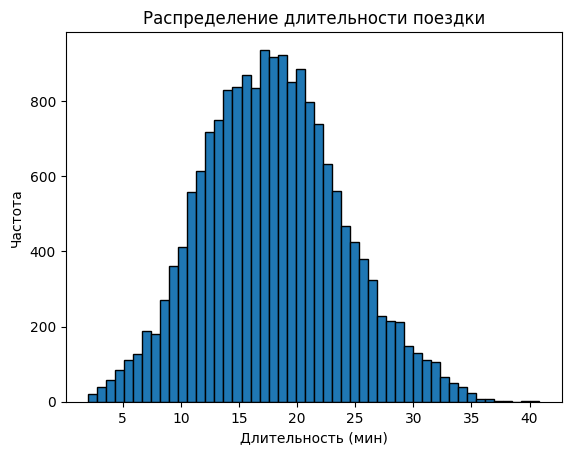

In [131]:
plt.hist(rides['duration'], bins=50, edgecolor='black')
plt.title('Распределение длительности поездки')
plt.xlabel('Длительность (мин)')
plt.ylabel('Частота')
plt.show()

In [132]:
min_duration = round(rides['duration'].min(), 2)
max_duration = round(rides['duration'].max(), 2)
median_duration = round(rides['duration'].median())

print(
f'Минимальная длительность поездки: {min_duration} мим.\n\
Максимальная длительность поездки: {max_duration} мин.\n\
Средняя длительность одной поездки: {median_duration} мин.')

Минимальная длительность поездки: 2.04 мим.
Максимальная длительность поездки: 40.82 мин.
Средняя длительность одной поездки: 18 мин.


Чаще всего поездки длятся от 15 до 25 минут.

По итогам исследовательского анализа данных выявлено:
- Самый часто встречающийся город - Пятигорск, а Москва на последнем месте;
- Пользователей без подписки больше (54%);
- Минимальный возраст пользователей: 12;
- Максимальный возраст пользователей: 43;
- Средний возраст: 25 лет;
- Больше всего пользуются сервисом в группе 20-30 лет;
- Минимальное расстояние поездки: 2.57 м.;
- Максимальное расстояние поездки: 7211.01 м.;
- Среднее расстояние за одну поездку: 3134 м.;
- Минимальная длительность поездки: 2.04 мим.;
- Максимальная длительность поездки: 40.82 мин.;
- Средняя длительность одной поездки: 18 мин.



#### 4. Объединение данных

4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм.

In [133]:
# Перед объединением ещё раз взглянем на кол-во записей в каждом датафрейме
print(
f'Количество строк в датасете "Пользователи": {len(users)}\n\
Количество строк в датасете "Поездки": {len(rides)}\n\
Количество строк в датасете "Подписки": {len(subscriptions)}'
)

Количество строк в датасете "Пользователи": 1534
Количество строк в датасете "Поездки": 18067
Количество строк в датасете "Подписки": 2


Видим, что датасет "Поездки" самый большой, соотвественно, после объединения количество записей должно соответствовать этому датасету.

In [134]:
# Объединение
merged_01= pd.merge(rides, users, on='user_id', how='outer')
merged_df = pd.merge(merged_01, subscriptions, on='subscription_type', how='outer')
merged_df

,user_id,distance,duration,date,month_number,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,"2,516",15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,847,16,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,"4,004",20,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,"1,206",10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,"3,047",17,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18062,699,"3,973",25,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
18063,699,"3,289",16,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
18064,699,"3,076",14,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
18065,699,"4,708",16,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [135]:
# Проверка корректности объединения
if len(merged_df) == len(rides):
    print('Объединение произошло корректно, количество записей верное.')
else:
    print('Объединение произошло не корректно.')

# Проверка на пропуски
missing_values = merged_df.isnull().sum()
if missing_values.sum() > 0:
    print('В датасете есть пропуски')
    print(missing_values)
else:
    print('В объединённом датасете нет пропусков.')

Объединение произошло корректно, количество записей верное.
В объединённом датасете нет пропусков.


4.2 Создайте ещё два датафрейма из датафрейма:
c данными о пользователях без подписки;
с данными о пользователях с подпиской.

In [136]:
# Пользователи с подпиской
users_w_subscription = merged_df.loc[merged_df['subscription_type']=='ultra']

# Пользователи без подписки
users_wo_subscription = merged_df.loc[merged_df['subscription_type']=='free']

In [137]:
users_w_subscription.head()

,user_id,distance,duration,date,month_number,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
11567,1,"4,410",26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
11568,1,"2,618",16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
11569,1,754,6,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
11570,1,"2,695",19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
11571,1,"4,029",26,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [138]:
users_wo_subscription.head()

,user_id,distance,duration,date,month_number,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,"2,516",15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,847,16,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,"4,004",20,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,"1,206",10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,"3,047",17,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [139]:
# Проверка корректности размера получившихся датовреймов
if len(users_w_subscription) + len(users_wo_subscription) == len(merged_df):
    print('Размер полученных датафреймов корректный.')
else:
    print('Размер полученных датафреймов корректный.')

Размер полученных датафреймов корректный.


4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

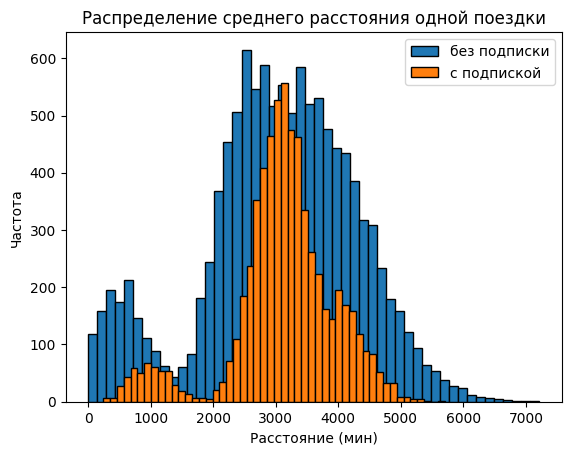

In [140]:
plt.hist(users_wo_subscription['distance'], bins=50, edgecolor='black', label='без подписки')
plt.hist(users_w_subscription['distance'], bins=50, edgecolor='black', label='с подпиской')
plt.title('Распределение среднего расстояния одной поездки')
plt.xlabel('Расстояние (мин)')
plt.ylabel('Частота')
plt.legend(loc='upper right')
plt.show()

In [141]:
distance_stats_wo_subscription = users_wo_subscription['distance'].describe()
distance_stats_w_subscription = users_w_subscription['distance'].describe()
merged_summary = pd.concat([distance_stats_wo_subscription, distance_stats_w_subscription], axis=1)
merged_summary.columns = ['distance_without_subscription', 'distance_with_subscription']
merged_summary

,distance_without_subscription,distance_with_subscription
count,"11,567","6,500"
mean,"3,046","3,115"
std,"1,246",837
min,3,244
25%,"2,367","2,785"
50%,"3,115","3,149"
75%,"3,906","3,561"
max,"7,211","5,700"


- Диапазон расстояния поездок без подписки шире диапазона с подпиской  (3 м. - 7211 м. и 244 м. - 5700 м. соответственно)
- Распределения имеют похожую форму: и с подпиской, и без можно наблюдать два всплека - на короткие расстояния (меньше 1 км.) и на расстояния в районе 2-3 км. 
- Поездки на расстояние больше 3 км. и менее 500 м. преобладают у пользователей без подписки.
- Как для поездок с подпиской, так и без среднее расстояние меньше медианного, что означает, что есть скос влево, что видно на графике - есть всплеск для поездок на малые расстояния.


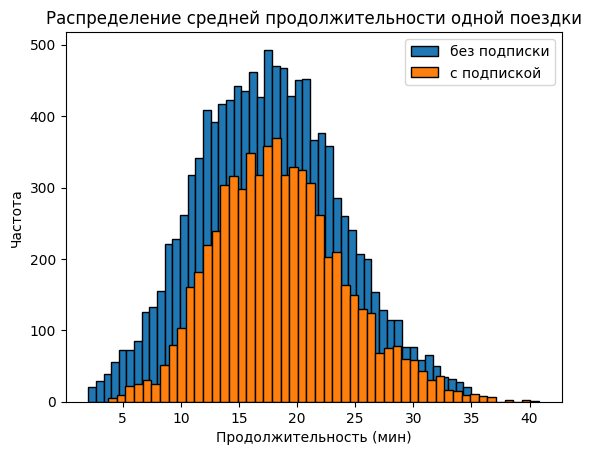

In [142]:
plt.hist(users_wo_subscription['duration'], bins=50, edgecolor='black', label='без подписки')
plt.hist(users_w_subscription['duration'], bins=50, edgecolor='black', label='с подпиской')
plt.title('Распределение средней продолжительности одной поездки')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Частота')
plt.legend(loc='upper right')
plt.show()

In [143]:
duration_stats_wo_subscription = users_wo_subscription['duration'].describe()
duration_stats_w_subscription = users_w_subscription['duration'].describe()
merged_summary = pd.concat([duration_stats_wo_subscription, duration_stats_w_subscription], axis=1)
merged_summary.columns = ['duration_without_subscription', 'duration_with_subscription']
merged_summary

,duration_without_subscription,duration_with_subscription
count,"11,567","6,500"
mean,18,19
std,6,6
min,2,4
25%,13,15
50%,17,18
75%,22,22
max,35,41


- Диапазоны продолжительности поездок без подписки и с подпиской приблизительно равны. Хотя пользователей без совершали больше краткосрочных поездок (до 5 мин.)
- Распределения имеют похожую форму близкую к нормальному с самым частым значением в 18-19 мин.
- Однако, частота совершения поездок без подписки выше.
- Как для поездок с подпиской, так и без среднее расстояние приблизительно равно медианному, что свидетельствет о том, что скоса в данных нет.


Объеденены датасеты с информацией о пользователях, поездках и подписках, с последующим извлечением данных для пользователей с подпиской и без. 

По результатам анализа длительности и расстояния поездок в обеих группах, можно сделать следующие выводы:
- Данные распределены похожим образом, однако пользователи без подписки совершают в целом больше поездок, чем с подпиской, в том числе больше кракткосрочнх поездок (на расстояние до 500 м. и по времени менее 5 м.) и больше длинных - более чем на 3 км.
- Самая частая длительность поездки составляет 17-18 мин, а расстояние 3 - 3.1 км.

#### 5. Подсчёт выручки

5.1 Новый датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными (суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.)

In [144]:
# каждое значение из столбца duration округляется с помощью «потолка»
merged_df['duration'] = np.ceil(merged_df['duration']) 

In [145]:
df = merged_df.groupby(['user_id', 'subscription_type', 'month_number']).agg(
    number_of_rides=('distance', 'count'), 
    total_distance=('distance', 'sum'), 
    total_duration=('duration', 'sum')
).reset_index()
df

,user_id,subscription_type,month_number,number_of_rides,total_distance,total_duration
0,1,ultra,1,2,"7,028",42
1,1,ultra,4,1,754,7
2,1,ultra,8,2,"6,723",46
3,1,ultra,10,2,"5,810",32
4,1,ultra,11,3,"7,003",56
...,...,...,...,...,...,...
11326,1534,free,6,2,"3,409",26
11327,1534,free,8,2,"7,622",48
11328,1534,free,9,1,"4,928",23
11329,1534,free,11,4,"13,350",78


5.2 Столбец с помесячной выручкой, которую принёс каждый пользователь.


In [146]:
def profit(row):
    if row['subscription_type'] == 'free':
        return 50 * row['number_of_rides'] + 8 * row['total_duration']
    elif row['subscription_type'] == 'ultra':
        return 199 + 6 * row['total_duration']
    else:
        return 0 

df['profit'] = df.apply(profit, axis=1)

In [147]:
df

,user_id,subscription_type,month_number,number_of_rides,total_distance,total_duration,profit
0,1,ultra,1,2,"7,028",42,451
1,1,ultra,4,1,754,7,241
2,1,ultra,8,2,"6,723",46,475
3,1,ultra,10,2,"5,810",32,391
4,1,ultra,11,3,"7,003",56,535
...,...,...,...,...,...,...,...
11326,1534,free,6,2,"3,409",26,308
11327,1534,free,8,2,"7,622",48,484
11328,1534,free,9,1,"4,928",23,234
11329,1534,free,11,4,"13,350",78,824


In [148]:
df.groupby('month_number')['profit'].agg(total_profit_per_month='sum').sort_values(by='total_profit_per_month', ascending=False)

,total_profit_per_month
month_number,
1,"339,548"
5,"338,729"
6,"336,874"
3,"331,830"
7,"329,824"
12,"328,117"
8,"327,138"
9,"324,237"
4,"324,228"


Самый прибыльный месяц январь, но это объясняется присутствием большего количества данных по южным городам.

### 6. Проверка гипотез

#### 6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Для проверки гипотезы о том, тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки, воспользуемся правосторонним двухвыборочным t-тестом.

Нулевая гипотеза (H0): Средняя продолжительность поездок для подписчиков и неподписчиков одинакова.

Альтернативная гипотеза (H1): Подписчики тратят на поездки больше времени, чем неподписчики.

In [149]:
alpha = 0.05

t_stat, p_value = st.ttest_ind(users_w_subscription['duration'], users_wo_subscription['duration'], alternative='greater')
print(f'Значение p-value = {p_value}')
if p_value < alpha:
    print(f'Значение p-value меньше стат.значимости, следовательно, отвергаем нулевую гипотезу в пользу альтернативной.')
else:
    print('Не удалось опровергнуть нулевую гипотезу в пользу альтернативной.')

Значение p-value = 1.7217693843668106e-25
Значение p-value меньше стат.значимости, следовательно, отвергаем нулевую гипотезу в пользу альтернативной.


По результатам статистического теста можно сделать вывод, что действительно, в среднем пользователи с подпиской тратят больше времени на поездки. Что таже было видно в шаге 4. (Среднее для подписчиков - 19 минут, а для пользователей без подписки - 18 минут.)

#### 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Для проверки гипотезы о том, не превышает ли среднее расстояние, которое проезжает пользователь с подпиской 3130 метров, воспользуемся правовторонним t-тестом.

Нулевая гипотеза (H0): Среднее расстояние пользователя с подпиской = 3130 метров.

Альтернативная гипотеза (H1): Среднее расстояние пользователя с подпиской больше 3130 метров.

In [150]:
alpha = 0.05

t_stat, p_value = st.ttest_1samp(users_w_subscription['distance'], 3130, alternative='greater')
print(f'Значение p-value = {p_value}')
if p_value < alpha:
    print(f'Значение p-value меньше стат.значимости, следовательно, отвергаем нудевую гипотезу в пользу альтернативной')
else:
    print('Не удалось опровергнуть нулевую гипотезу в пользу альтернативной.')
print('Cреднее значение выборки:', users_w_subscription['distance'].mean())

Значение p-value = 0.9195368847849785
Не удалось опровергнуть нулевую гипотезу в пользу альтернативной.
Cреднее значение выборки: 3115.4453880370247


Исходя из проведённого теста, можно сделать вывод, что у нас недостаточно данных для того, чтобы утверждать, что среднее расстояние для подписчиков превышает 3130 метров.
По выборке видно также, что среднее расстояние несколько ниже указанного 3130, что в целом может показывать, что самокаты не будут выходить из строя ранее положенного срока.

#### 6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Для проверки этой гипотезы воспользуемся t-тестом для независимых выборок, чтобы сравнить среднюю выручку от пользователей с подпиской и без подписки. В данном случае:

Нулевая гипотеза (H0): Средняя выручка от пользователей с подпиской не отличается от средней выручки от пользователей без подписки.

Альтернативная гипотеза (H1): Средняя выручка от пользователей с подпиской выше, чем средняя выручка от пользователей без подписки.

In [151]:
alpha = 0.05
sample_1 = df.loc[df['subscription_type']=='ultra', 'profit']
sample_2 = df.loc[df['subscription_type']=='free', 'profit']

t_stat, p_value = st.ttest_ind(sample_1, sample_2, alternative='greater')
print(f'Значение p-value = {p_value}')

if p_value < alpha:
    print(f'Значение p-value меньше стат.значимости, следовательно, отвергаем нудевую гипотезу в пользу альтернативной')
else:
    print('Не удалось опровергнуть нулевую гипотезу в пользу альтернативной')

Значение p-value = 5.278918749805128e-27
Значение p-value меньше стат.значимости, следовательно, отвергаем нудевую гипотезу в пользу альтернативной


По представленным данным можно сделать вывод, что средняя выручка от пользователей с подпиской выше, чем средняя выручка от пользователей без подписки, что может быть использовано в дальнейшем для улучшения условий подписки, новых акций и привелечения новых подписчиков. 

Вывод: средняя выручка от пользователей с подпиской выше, чем от пользователей без подписки.

#### 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось после обновления серверов, можно использовать односторонний t-тест для зависимых выборок.

В данном случае:

Нулевая гипотеза (H0): Среднее количество обращений в техподдержку до и после обновления серверов одинаково.

Альтернативная гипотеза (H1): Среднее количество обращений в техподдержку после обновления серверов меньше, чем до обновления.

Примерный код:
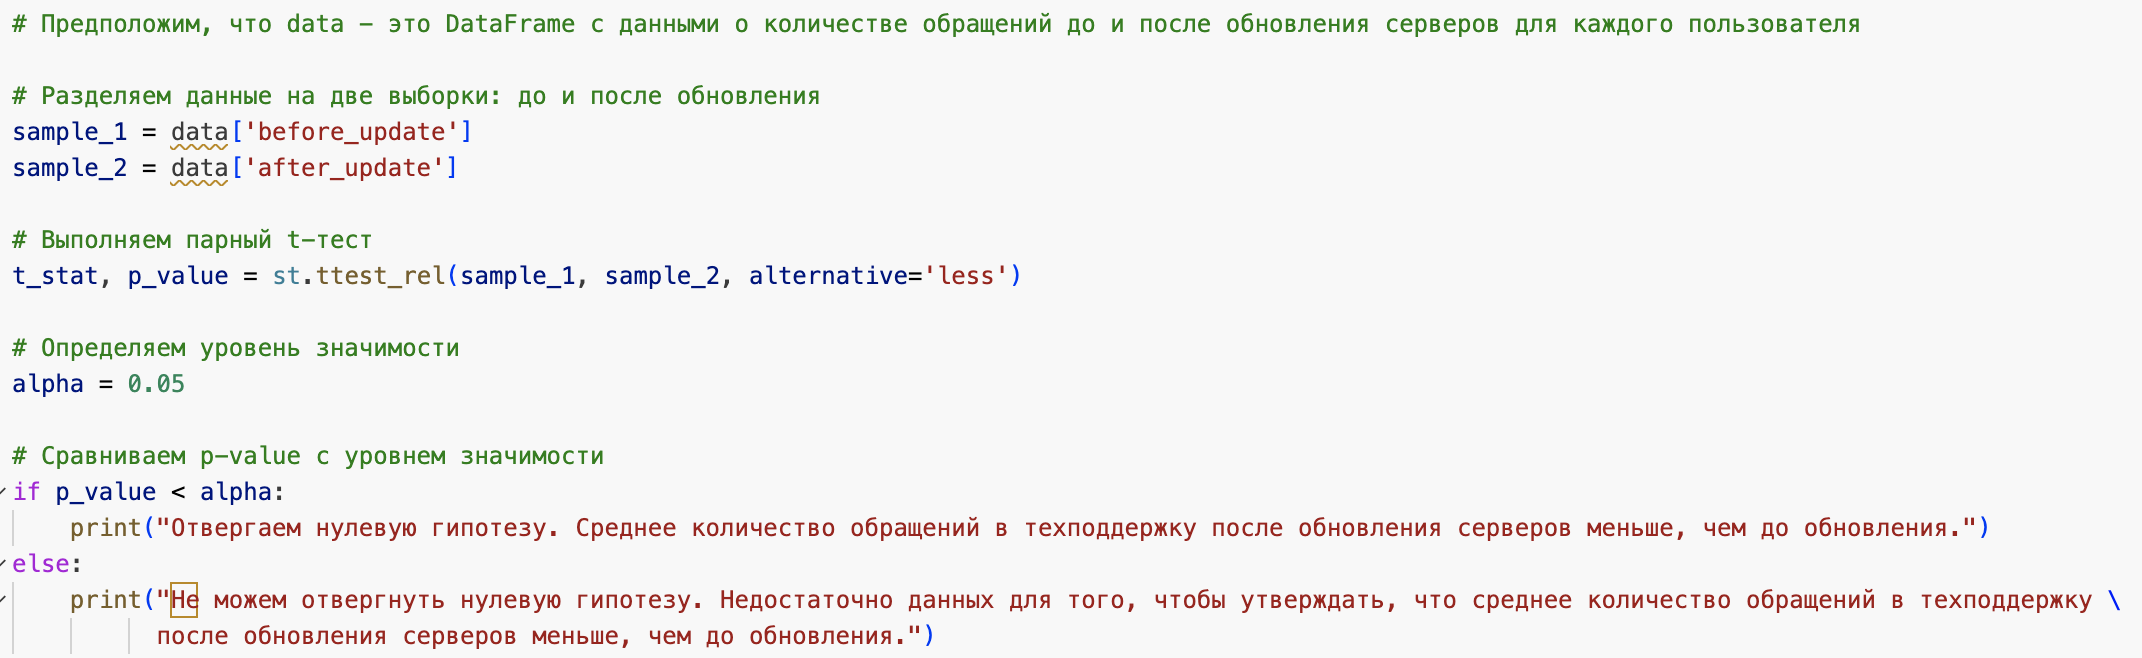

### 7. Распределения

#### 7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

- В данном случае подойдёт биномиальное распределение, т.к. случай с каждым клиентом - это независимое испытание Бернулли с двумя исходами (клиент продлит подписку - успех, клиент не продлит подписку - неудача).
- Всего испытаний - 100, вероятность успеха для каждого эксперимента одинаковая и составляет 10%, т.е. 0.1.

Text(0.5, 1.0, 'Биномиальное распределение продления подписки')

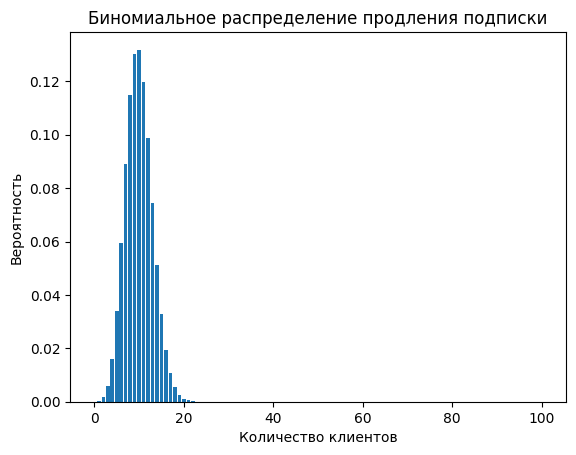

In [153]:
# Количечество существующих клиентов / экспериментов Бернулли
experiments = 100

# Вероятность продления подписки
p_success = 0.1 

distr = []

for k in range(0, experiments+1):
    collection = factorial(experiments)/(factorial(k) * factorial(experiments-k))
    prob = collection * p_success**k * (1-p_success)**(experiments-k)
    distr.append(prob)

plt.bar(range(0, experiments+1), distr)
plt.xlabel('Количество клиентов')
plt.ylabel('Вероятность')
plt.title('Биномиальное распределение продления подписки')

Text(0.5, 1.0, 'Биномиальное распределение продления подписки')

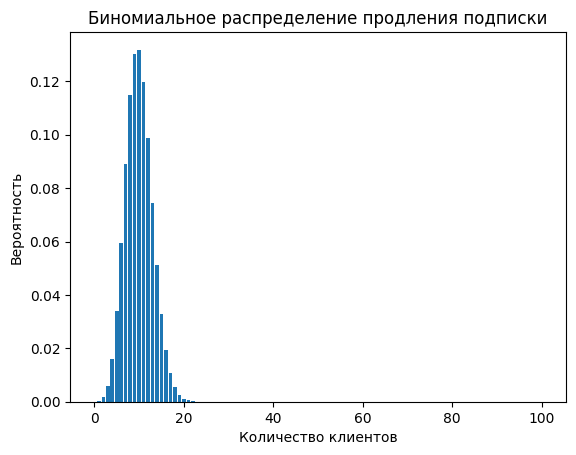

In [154]:
x = range(0, experiments + 1)
y = binom.pmf(x, experiments, p_success)
plt.bar(x, y)
plt.xlabel('Количество клиентов')
plt.ylabel('Вероятность')
plt.title('Биномиальное распределение продления подписки')

- Из распределения видно, что значение с наибольшей вероятностью, т.е. то количество клиентов из 100, которое продлит подписку с максимальной вероятностью - 10.
- Теперь необходимо найти такое количество клиентов, при котором вероятность продления составит примерно 5%.
- Из графика видно, что это где-то 5, но проверим это, используя кумулятивную функцию (как указано в ТЗ), которая покажет будет ли вероятность при числе успехов (клиентов, продливших подписку) менее/равным 5-ти составлять 5%.

In [155]:
# вероятность, что кол-во успехов меньше или равно 5
k = 5
p_failure = binom.cdf(k, experiments, p_success)
print("Probability of <= 5 successes:", p_failure)

Probability of <= 5 successes: 0.05757688648703396


Но удобнее найти число успехов, при котором вероятность составит 5%, используя функцию ppf. Она должна вернуть нам значение = 5. Проверим.

In [156]:
# значение, при котором вероятность 5%
p_failure = 0.05
k = binom.ppf(p_failure, experiments, p_success)
print("Value such that P(X <= k) = 0.5:", k)

Value such that P(X <= k) = 0.5: 5.0


Все верно, получается, что при вероятности в 5% минимальное количество успехов должно быть 5. 

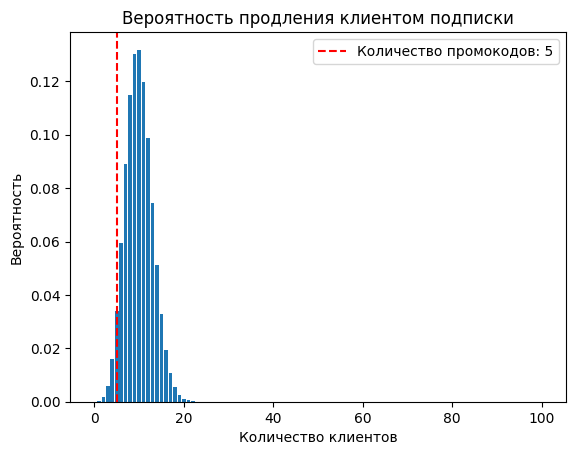

Минимальное количество промокодов, которое нужно разослать: 5


In [157]:
n_promo_codes = k
plt.bar(x, y)
plt.xlabel('Количество клиентов')
plt.ylabel('Вероятность')
plt.title('Вероятность продления клиентом подписки')
plt.axvline(n_promo_codes, color='r', linestyle='--', label=f'Количество промокодов: {int(n_promo_codes)}')
plt.legend()
plt.show()

print(f"Минимальное количество промокодов, которое нужно разослать: {int(n_promo_codes)}")

#### 7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

- В данном случает речь также идёт о биномиальном распределении (клиент открыл уведомление - успех, не открыл - неудача).
- Часто условиями аппроксимации биномиального распределения нормальным являются достаточно большое n и p около 0.5. Считаю, что в данном случае n = 1000000 можно считать большим и p = 0.4 можно считать близким к 0.5.
- Однако, проверим, выполняется ли следующее условие: Если промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения  лежит в пределах то аппроксимацию можно использовать.

In [158]:
n = 1000000  # кол-во испытаниц
p = 0.4  # вероятность успеха

# среднее и стандартное отклонение
mean = n * p
std_dev = math.sqrt(n * p * (1 - p))

# границы интервала
interval_lower = mean - 3 * std_dev
interval_upper = mean + 3 * std_dev

# проверяем, лежит ли интервал в пределах диапазона биномиального распределения
if interval_lower >= 0 and interval_upper <= n:
    print("Интервал лежит в пределах диапазона биномиального распределения.")
    print("Нормальная аппроксимация может быть использована.")
else:
    print("Интервал не лежит в пределах диапазона биномиального распределения.")
    print("Нормальная аппроксимация может быть не подходящей.")

Интервал лежит в пределах диапазона биномиального распределения.
Нормальная аппроксимация может быть использована.


- Построим график аппроксимации нормальным распеределением.
- Найти вероятность того, что уведомление откроют не более 399,5 тыс. пользователей поможет функция cdf.

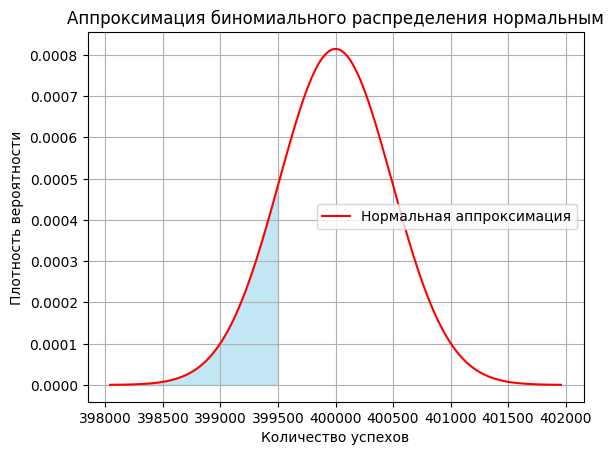

In [159]:
# значения x для графика
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# плотность вероятности (PDF) нормального распределения
pdf = norm.pdf(x, loc=mean, scale=std_dev)

plt.plot(x, pdf, label='Нормальная аппроксимация', color='red')
plt.fill_between(x, norm.pdf(x, mean, std_dev), where=(x <= 399500), color='skyblue', alpha=0.5)

plt.xlabel('Количество успехов')
plt.ylabel('Плотность вероятности')
plt.title('Аппроксимация биномиального распределения нормальным')
plt.legend()
plt.grid(True)
plt.show()

In [160]:
probability = round((norm.cdf(399500, mean, std_dev))*100)
print(f'Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: {probability}%')

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15%


#### Выводы и рекомендации:

По результатам исследовательского анализа данных сервиса проката самокатов GoFast была получена ценная информация, которая может помочь оптимизировать работу и улучшить качество предоставляемых услуг.

- Популярность сервиса в Пятигорске: Судя по данным, сервис проката самокатов GoFast пользуется наибольшей популярностью в городе Пятигорске. Это может быть признаком того, что рынок в этом городе имеет потенциал для дальнейшего развития и расширения услуг.

- Подписки и пользователи: Большинство пользователей (54%) не имеют подписки. Это может указывать на необходимость дальнейшего привлечения клиентов к услугам подписки через привлекательные предложения и льготные условия.

- Характеристики пользователей: Большинство пользователей сервиса находятся в возрастной группе от 20 до 30 лет. Это может помочь в формировании маркетинговых стратегий и продвижении услуг с учетом предпочтений и потребностей этой целевой аудитории.

- Характеристики поездок: Длительность и расстояние поездок имеют свои характеристики. Большинство поездок имеют относительно короткое расстояние и продолжительность, что может указывать на предпочтение пользователей использовать сервис для краткосрочных поездок внутри города.

- Выручка от подписок: Данные показывают, что средняя выручка от пользователей с подпиской выше, чем от пользователей без подписки. Это может свидетельствовать о преимуществах и привлекательности услуг подписки для пользователей.

- Контроль состояния самокатов: Анализ среднего расстояния поездки также указывает на то, что самокаты в целом не выходят из строя ранее положенного срока, что является положительным сигналом для бизнеса и позволяет экономить на обслуживании и ремонте оборудования.

На основе этих выводов рекомендуется:

- Увеличить количество пользователей с подпиской: Разработать маркетинговые стратегии, направленные на привлечение новых пользователей к услугам подписки, предлагая привлекательные условия и бонусы.

- Оптимизировать условия подписки: Изучить предпочтения пользователей и оптимизировать условия подписки, чтобы они были более привлекательными и соответствовали потребностям клиентов.

Эти рекомендации помогут компании GoFast улучшить свою конкурентоспособность на рынке и повысить удовлетворенность клиентов.
